In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier, StackingRegressor, StackingClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
from sklearn.neighbors import KNeighborsRegressor


#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
import pydotplus

# Linear Regression Libraries
import statsmodels.formula.api as smf
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# MARS
from pyearth import Earth
import time as time

import xgboost as xgb
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier


np.warnings.filterwarnings('ignore')

In [2]:
# original data
data = pd.read_csv('train.csv')
validation_data = pd.read_csv('test.csv')

In [3]:
# data cleaning
state_freqs = data.addr_state.value_counts().to_frame().reset_index().rename(columns={'index' : "state", "addr_state" : "count"})
other_state = state_freqs[state_freqs['count'] < data.shape[0] * .01]['state'].tolist()

def clean(data):
    
    df = data.copy()
    # addr_state: 'other' category
    for obs in range(df.shape[0]):
        if df.loc[obs, 'addr_state'] in other_state:
            df.loc[obs, 'addr_state'] = 'Other'
            
    # earliest_cr_line: split month, year
    df['earliest_cr_line_month'] = df.earliest_cr_line.str.split('-', expand = True)[0]
    df['earliest_cr_line_year'] = df.earliest_cr_line.str.split('-', expand = True)[1].astype(int)
    df.drop(columns = ['earliest_cr_line'], inplace = True)
    
    # last_credit_pull_d: split month, year
    df['last_credit_pull_d_month'] = df.last_credit_pull_d.str.split('-', expand = True)[0]
    df['last_credit_pull_d_year'] = df.last_credit_pull_d.str.split('-', expand = True)[1].astype(int)
    df.drop(columns = 'last_credit_pull_d', inplace = True)
    
    # sub_grade: remove numeric ratings, group F and G into 'other'
    df['sub_grade_letter'] = df['sub_grade'].str.extract('([A-Z]+)')
    df.loc[df["sub_grade_letter"] == "F", "sub_grade_letter"] = "Other"
    df.loc[df["sub_grade_letter"] == "G", "sub_grade_letter"] = "Other"
    df.drop(columns = 'sub_grade', inplace = True)
    
    # drop 'id' columns
    df.drop(columns = 'id', inplace = True)
    
    return df
    


In [4]:
train = clean(data) # train 
test = clean(validation_data) # kaggle 

In [5]:
# filter for predictors
X = train.drop(columns = ['money_made_inv'])
# filter for response
y = train['money_made_inv']

# 70% of training data becomes the new train set, 30% becomes new test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = int(train.shape[0]*.7), random_state = 1)


In [6]:
# numeric predictors
Xtrain_num = Xtrain.select_dtypes(include=np.number)
Xtest_num = Xtest.select_dtypes(include=np.number)

# categorical predictors
Xtrain_cat = Xtrain[['sub_grade_letter', 'term', 'initial_list_status', 'application_type']]
Xtest_cat = Xtest[['sub_grade_letter', 'term', 'initial_list_status', 'application_type']]

# numeric and categorical predictors
Xtrain_num_cat = pd.concat([Xtrain_num, pd.get_dummies(Xtrain_cat)],axis=1)
Xtest_num_cat = pd.concat([Xtest_num, pd.get_dummies(Xtest_cat)],axis=1)


# Random Forest

In [46]:
#Finding model accuracy vs number of trees
oob_rsquared={};test_rsquared={};oob_rmse={};test_rmse = {}

for i in np.linspace(350,600,25,dtype=int):
    
    model = RandomForestRegressor(n_estimators=i, random_state=1,max_features="sqrt",
                        n_jobs=-1,oob_score=True).fit(Xtrain_num_cat, ytrain)
    
    oob_rsquared[i]=model.oob_score_  #Returns the out-of_bag R-squared of the model
    
    test_rsquared[i]=model.score(Xtest_num_cat,ytest) #Returns the test R-squared of the model
    
    oob_rmse[i]=np.sqrt(mean_squared_error(model.oob_prediction_,ytrain))
    
    test_rmse[i]=np.sqrt(mean_squared_error(model.predict(Xtest_num_cat),ytest))
    
    
    

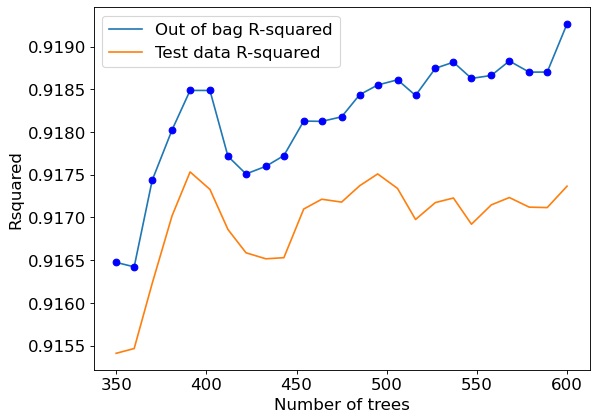

In [47]:
# OOB and test r^2
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_rsquared.keys(),oob_rsquared.values(),label = 'Out of bag R-squared')
plt.plot(oob_rsquared.keys(),oob_rsquared.values(),'o',color = 'blue')
plt.plot(test_rsquared.keys(),test_rsquared.values(), label = 'Test data R-squared')
plt.xlabel('Number of trees')
plt.ylabel('Rsquared')
plt.legend()

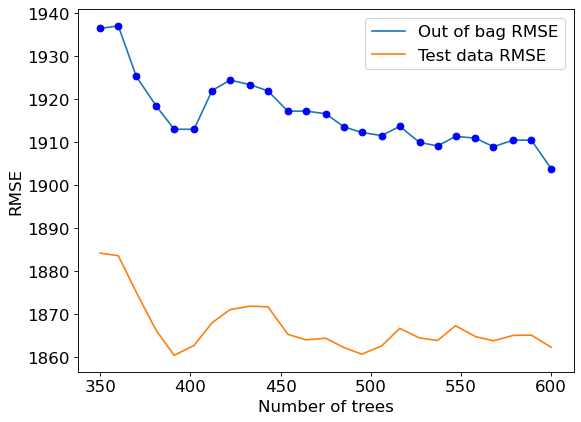

In [48]:
#Visualizing out-of-bag RMSE and test data RMSE
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_rmse.keys(),oob_rmse.values(),label = 'Out of bag RMSE')
plt.plot(oob_rmse.keys(),oob_rmse.values(),'o',color = 'blue')
plt.plot(test_rmse.keys(),test_rmse.values(), label = 'Test data RMSE')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()

In [52]:
#Optimizing with OOB score takes half the time as compared to cross validation. 
#The number of models developed with OOB score tuning is one-fifth of the number of models developed with
#5-fold cross validation

# NOTE: THIS TUNES MULTIPLE PARAMETERS AT A TIME WITHOUT GRIDSEARCH

start_time = time.time()

n_samples = train.shape[0]
n_features = train.shape[1]

params = {'n_estimators': [400, 450, 500, 550, 600],
          #'max_depth': [12,15,18],
          #'max_leaf_nodes':[1100,1200,1300],
          'max_features': range(20, 30)}

# NOTE: creates list of combinations of all parameter values
param_list=list(it.product(*(params[Name] for Name in params)))

# for each potential model (108 in this case)
oob_score = [0]*len(param_list) # len(param_list) = # possible parameter combinations: 3*3*3*4 = 108


i=0

for pr in param_list:
    model = RandomForestRegressor(random_state=1,oob_score=True,verbose=False,
                                  n_estimators = pr[0],
                                  #max_depth=pr[1],
                                  #max_leaf_nodes=pr[2],
                                  max_features=pr[1],
                                  n_jobs=-1).fit(Xtrain_num_cat,ytrain)
    oob_score[i] = model.oob_score_
    i=i+1 # adding 1 -> next model
    
end_time = time.time()
print("time taken = ", (end_time-start_time)/60, " minutes")
print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))


time taken =  6.170273280143737  minutes
Best params =  (450, 28)
Best score (R-squared) =  0.9870793373355412


In [57]:
# current model
rf_model = RandomForestRegressor(n_estimators=450,
                                 random_state=1,
                                 max_features = 28, 
                                 max_depth = 13,
                                 n_jobs=-1).fit(Xtrain_num_cat, ytrain)

pred_rf = rf_model.predict(Xtest_num_cat)
np.sqrt(mean_squared_error(pred_rf,ytest))

857.9485511112829

In [55]:
# # prior to new tuning (864.8688754417179)
# rf_model = RandomForestRegressor(n_estimators=400,
#                                  random_state=1,
#                                  max_features = 30, 
#                                  max_depth = 13,
#                                  n_jobs=-1).fit(Xtrain_num_cat, ytrain)
# pred_rf = rf_model.predict(Xtest_num_cat)
# np.sqrt(mean_squared_error(pred_rf,ytest))